In [359]:
import pandas as pd
import numpy as np
from utils import rmspe
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

In [360]:
import os
import re
stock_ids = sorted(
    [int(re.sub('stock_id=', '', x)) for x in os.listdir('book_train.parquet')])

In [361]:
sample_submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')

In [362]:

to_merge = []

for stock_id in tqdm(stock_ids):
    book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
    trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

    book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
    book['ask_size1'] + book['bid_size1'])
    
    book['log_price'] = np.log(book['wap'])
    book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
    book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
    book = book[~book['log_return'].isnull()]
    book['stock_id'] = stock_id
    
    temp = book.groupby(['time_id', 'stock_id'])['log_return'].agg(lambda x: np.sum(x ** 2) ** 0.5) 

    to_merge.append(temp)



  0%|          | 0/112 [00:00<?, ?it/s]

  1%|          | 1/112 [00:02<04:40,  2.53s/it]

  2%|▏         | 2/112 [00:04<04:33,  2.48s/it]

  3%|▎         | 3/112 [00:07<04:27,  2.45s/it]

  4%|▎         | 4/112 [00:09<04:21,  2.42s/it]

  4%|▍         | 5/112 [00:11<04:08,  2.32s/it]

  5%|▌         | 6/112 [00:13<04:04,  2.30s/it]

  6%|▋         | 7/112 [00:16<03:59,  2.28s/it]

  7%|▋         | 8/112 [00:18<03:56,  2.27s/it]

  8%|▊         | 9/112 [00:20<03:54,  2.28s/it]

  9%|▉         | 10/112 [00:23<04:04,  2.40s/it]

 10%|▉         | 11/112 [00:26<04:35,  2.73s/it]

 11%|█         | 12/112 [00:30<04:44,  2.84s/it]

 12%|█▏        | 13/112 [00:33<04:52,  2.96s/it]

 12%|█▎        | 14/112 [00:36<04:55,  3.02s/it]

 13%|█▎        | 15/112 [00:39<04:47,  2.96s/it]

 14%|█▍        | 16/112 [00:42<04:47,  2.99s/it]

 15%|█▌        | 17/112 [00:45<04:45,  3.00s/it]

 16%|█▌        | 18/112 [00:48<04:35,  2.93s/it]

 17%|█▋        | 19/112 [00:50<04:31,  2.92s/it]

 18%|█▊        |

In [363]:
temp = pd.concat(to_merge)

In [369]:
merged = pd.merge(train, temp.reset_index(), on=['time_id', 'stock_id'])
merged.rename(columns={'log_return': 'pred'}, inplace=True)

In [374]:
merged.to_csv('prev_targer.csv')

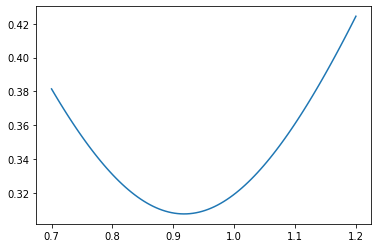

In [365]:
grid = np.linspace(0.7, 1.2, 100)
plt.plot(grid, [rmspe(merged['log_return'], x * merged['target']) for x in grid])

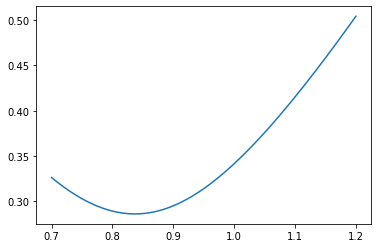

In [366]:
grid = np.linspace(0.7, 1.2, 100)
plt.plot(grid, [rmspe(merged['target'], x * merged['log_return']) for x in grid])

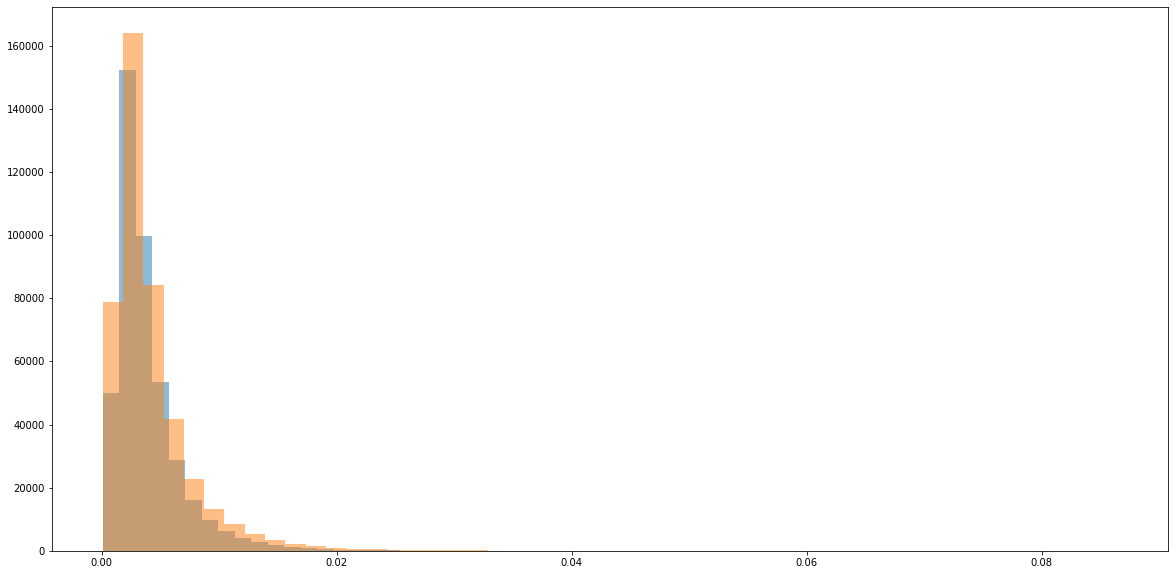

In [24]:
plt.figure(figsize=(20, 10))
plt.hist(merged['target'], 50, alpha=0.5)
plt.hist(merged['log_return'], 50, alpha=0.5)
plt.show()

In [25]:
merged[['target', 'log_return']].describe()

,target,log_return
count,428932.000000,428932.000000
mean,0.003880,0.004233
std,0.002936,0.003586
min,0.000105,0.000081
25%,0.002026,0.002065
50%,0.003048,0.003159
75%,0.004738,0.005108
max,0.070321,0.086421


In [182]:
res = []
answer = []
grid = np.linspace(0.7, 1.2, 100)
for _ in trange(100):
    bern = np.random.binomial(1, p=0.5, size=len(merged))
    
    target = np.where(bern, merged['target'], merged['log_return'])
    pred = np.where(bern, merged['log_return'], merged['target'])
    
    grid = np.linspace(0.8, 1, 30)
    temp = [rmspe(target, x * pred) for x in grid]
    x = grid[np.argmin(temp)]
    res.append(x)
    answer.append(np.max(temp))



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:14,  6.89it/s]

  2%|▏         | 2/100 [00:00<00:14,  6.94it/s]

  3%|▎         | 3/100 [00:00<00:13,  7.14it/s]

  4%|▍         | 4/100 [00:00<00:12,  7.48it/s]

  5%|▌         | 5/100 [00:00<00:12,  7.68it/s]

  6%|▌         | 6/100 [00:00<00:12,  7.78it/s]

  7%|▋         | 7/100 [00:00<00:11,  7.92it/s]

  8%|▊         | 8/100 [00:01<00:11,  7.95it/s]

  9%|▉         | 9/100 [00:01<00:11,  7.84it/s]

 10%|█         | 10/100 [00:01<00:11,  7.55it/s]

 11%|█         | 11/100 [00:01<00:11,  7.65it/s]

 12%|█▏        | 12/100 [00:01<00:11,  7.82it/s]

 13%|█▎        | 13/100 [00:01<00:11,  7.88it/s]

 14%|█▍        | 14/100 [00:01<00:10,  7.90it/s]

 15%|█▌        | 15/100 [00:01<00:10,  7.73it/s]

 16%|█▌        | 16/100 [00:02<00:11,  7.55it/s]

 17%|█▋        | 17/100 [00:02<00:10,  7.66it/s]

 18%|█▊        | 18/100 [00:02<00:10,  7.56it/s]

 19%|█▉        | 19/100 [00:02<00:10,  7.58it/s]

 20%|██        |

In [183]:
np.mean(target > pred)

0.5006318017774379

In [184]:
np.min(res), np.max(res), np.mean(res)

(0.8689655172413794, 0.8758620689655172, 0.873793103448276)

In [185]:
np.unique(res, return_counts=True)

(array([0.86896552, 0.87586207]), array([30, 70]))

In [353]:
spliters = np.linspace(0, 0.1, 30, np.inf)
x1 = []
y1 = []

for t in range(1, len(spliters)):
    bern = np.random.binomial(1, p=0, size=len(merged))
    target = np.where(bern, merged['target'], merged['log_return'])
    pred = np.where(bern, merged['log_return'], merged['target'])

    grid = np.linspace(0.1, 1.2, 100)
    inds = (pred > spliters[t - 1]) & (pred <= spliters[t])
    temp = [rmspe(target[inds], x * pred[inds]) for x in grid]
    x = grid[np.argmin(temp)]
    y = np.min(temp)
    x1.append(x)
    y1.append(y)

/home/dro/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dro/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [354]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [355]:
poly = PolynomialFeatures(degree=3, )
poly.fit(pred.reshape(-1, 1))

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

In [356]:
x = np.array(spliters[1: ])
x = np.stack([x, x**2, x**3, x**4]).T
y = x1

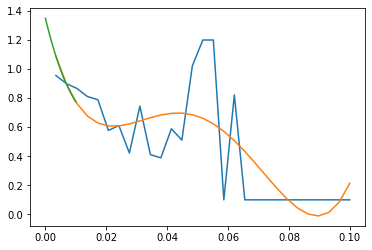

In [357]:
reg = LinearRegression()
reg.fit(x, y)
plt.plot(x[:, 0], y)
plt.plot(x[:, 0], reg.predict(x))
x_temp = np.linspace(0, 0.01, 100)
plt.plot(x_temp, reg.predict(np.stack([x_temp, x_temp**2, x_temp**3, x_temp**4]).T))

In [358]:
rmspe(target, pred * reg.predict(np.stack([pred, pred**2, pred**3, pred**4]).T))

0.35081897165794595

In [339]:
temp = reg.predict(np.stack([pred, pred**2, pred**3, pred**4]).T)

In [340]:
pred.max()

0.08642106503248215

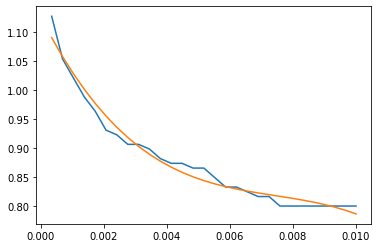

In [268]:
reg = LinearRegression()
reg.fit(x, y)
plt.plot(x[:, 0], y)
plt.plot(x[:, 0], reg.predict(x))

array([[3.44827586e-04, 1.18906064e-07, 4.10020911e-11],
       [6.89655172e-04, 4.75624257e-07, 3.28016729e-10],
       [1.03448276e-03, 1.07015458e-06, 1.10705646e-09],
       [1.37931034e-03, 1.90249703e-06, 2.62413383e-09],
       [1.72413793e-03, 2.97265161e-06, 5.12526139e-09],
       [2.06896552e-03, 4.28061831e-06, 8.85645168e-09],
       [2.41379310e-03, 5.82639715e-06, 1.40637172e-08],
       [2.75862069e-03, 7.60998811e-06, 2.09930706e-08],
       [3.10344828e-03, 9.63139120e-06, 2.98905244e-08],
       [3.44827586e-03, 1.18906064e-05, 4.10020911e-08],
       [3.79310345e-03, 1.43876338e-05, 5.45737833e-08],
       [4.13793103e-03, 1.71224732e-05, 7.08516134e-08],
       [4.48275862e-03, 2.00951249e-05, 9.00815942e-08],
       [4.82758621e-03, 2.33055886e-05, 1.12509738e-07],
       [5.17241379e-03, 2.67538644e-05, 1.38382057e-07],
       [5.51724138e-03, 3.04399524e-05, 1.67944565e-07],
       [5.86206897e-03, 3.43638526e-05, 2.01443274e-07],
       [6.20689655e-03, 3.85255

In [58]:
merged['a>t'] = merged['log_return'] > merged['target']

In [105]:
bad_time_ids = merged.groupby('time_id')['a>t'].mean().sort_values().tail(100).index.values

In [106]:
book.groupby('seconds_in_bucket')

In [135]:
stock_id = 5

book = pd.read_parquet('book_train.parquet/stock_id=' + str(stock_id))
trades = pd.read_parquet('trade_train.parquet/stock_id=' + str(stock_id))

book['wap'] = (book['bid_price1'] * book['ask_size1'] + book['ask_price1'] * book['bid_size1']) / (
book['ask_size1'] + book['bid_size1'])

book['log_price'] = np.log(book['wap'])
book['bucket_in_bucket'] = book['seconds_in_bucket'] // 100
book['log_return'] = book.groupby(['time_id'])['log_price'].diff()
book = book[~book['log_return'].isnull()]
book['square_return'] = book['log_return'] ** 2
book['spread'] = book['ask_price1'] - book['bid_price1']
book['stock_id'] = stock_id

book = pd.merge(book, trades, on=['time_id', 'seconds_in_bucket'], how='left')
book['is_trade'] = book['size'] > 0

<AxesSubplot:xlabel='seconds_in_bucket'>

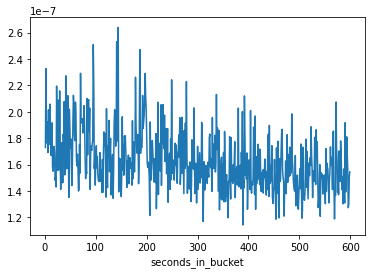

In [136]:
book[book.time_id.apply(lambda x: x not in bad_time_ids)].groupby(
    'seconds_in_bucket')['log_return'].agg(lambda x: np.square(x).mean()).plot()

In [143]:
book.groupby(['time_id', 'is_trade'])[['square_return']].mean()

square_return
time_id is_trade               
5       False      8.288841e-08
        True       3.095564e-07
11      False      5.684930e-09
        True       4.703467e-08
16      False      2.144320e-08
...                         ...
32758   True       4.362711e-08
32763   False      4.126760e-08
        True       2.001758e-07
32767   False      2.790630e-08
        True       9.503977e-08

[7660 rows x 1 columns]

<AxesSubplot:>

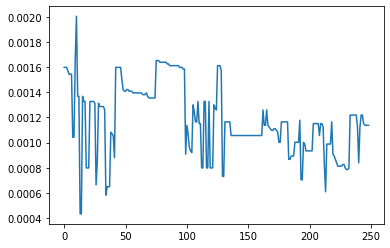

In [148]:
book[book.time_id == 5]['spread'].plot()